In [9]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
from classes.paths import LocalPaths
from classes.classes import ColorManager
from evaluation.utils import load_wandb_runs
from classes.classes import MODEL_CONFIGS, NO_COSTS_MODEL_CONFIGS
from dotenv import load_dotenv
from evaluation.evaluation_metrics import SelectedRuntime
from evaluation.utils import get_model_results
import pandas as pd
from classes.workloads import EvalWorkloads
from classes.classes import MODEL_CONFIGS
from classes.classes import ModelName
import matplotlib.patches as mpatches

load_dotenv()
sns.set_theme(style="whitegrid", font_scale=1.8)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
training_results = load_wandb_runs(wandb_user= os.environ["WANDB_USER"], 
                                   wandb_project=os.environ["WANDB_PROJECT"], 
                                   result_dir=LocalPaths().data / "training"/ "results.csv", 
                                   model_confs=MODEL_CONFIGS)
training_results

,model,database,seed,val_time,val_num_tuples,val_loss,val_std,val_mse,val_mape,val_median_q_error_50,val_median_q_error_95,val_median_q_error_100,test_time,no_test_points,display_name
0,postgres,baseball,2,NaN,NaN,NaN,NaN,4.431795,8.437770,7.760199,23.804813,60.607624,0.000393,5000.0,Sc. Postgres
1,postgres,imdb,2,NaN,NaN,NaN,NaN,7.600937,3.047728,3.495369,13.968419,25.392546,0.000537,10000.0,Sc. Postgres
2,postgres,tpc_h,2,NaN,NaN,NaN,NaN,5.940187,4.319689,2.833187,19.890733,25.848415,0.000354,10000.0,Sc. Postgres
3,postgres,baseball,1,NaN,NaN,NaN,NaN,4.427171,8.499110,7.771549,23.977192,59.395131,0.000286,5000.0,Sc. Postgres
4,postgres,tpc_h,1,NaN,NaN,NaN,NaN,5.933778,4.302132,2.828099,19.809247,25.733105,0.000423,10000.0,Sc. Postgres
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,dace,imdb,1,6.766429,10048.0,0.467642,7.485918,4.656119,0.460529,1.278169,3.222375,9.312226,NaN,NaN,DACE
76,dace,tpc_h,1,6.263767,10048.0,0.514632,6.018817,4.616790,0.316243,1.278786,3.741360,26.321440,NaN,NaN,DACE
77,dace,imdb,0,5.513473,10048.0,0.468080,7.485918,4.452060,0.431560,1.281085,3.216513,9.422543,NaN,NaN,DACE
78,dace,tpc_h,0,6.377806,10048.0,0.498211,6.018817,4.664309,0.328196,1.296683,3.666642,26.694092,NaN,NaN,DACE


In [11]:
runtime_df = pd.DataFrame()
minimal_runtimes = []
for workload in EvalWorkloads.FullJoinOrder.imdb:
    results = get_model_results(workload, MODEL_CONFIGS)
    for model in MODEL_CONFIGS:
        model_results = results[results["model"] == model.name.DISPLAY_NAME]
        selected_runtime = SelectedRuntime().evaluate_metric(preds=model_results["prediction"], labels=model_results['runtime'])
        runtime_df.loc[model.name.DISPLAY_NAME, workload.get_workload_name()] = selected_runtime
    minimal_runtimes.append(model_results["label"].min())
runtime_df

,job_light_0,job_light_1,job_light_2,job_light_3,job_light_4,job_light_5,job_light_6,job_light_8,job_light_9,job_light_10,...,job_light_54,job_light_55,job_light_61,job_light_62,job_light_63,job_light_64,job_light_65,job_light_66,job_light_67,job_light_68
Sc. Postgres,0.543450,0.323863,0.547615,0.322841,0.919035,15.671644,9.629687,1.971370,1.346595,2.456559,...,2.184262,4.718174,22.512904,19.228458,18.537919,2.505479,12.099539,9.724024,7.323562,5.091506
Flat Vector,0.543450,0.805404,0.795874,0.885361,0.919035,15.671644,9.629687,5.913082,1.638008,4.146114,...,2.184262,4.718174,26.863329,17.534379,29.670713,2.235798,12.099539,10.367956,10.655318,7.024411
MSCN,1.617932,1.258533,1.224779,2.820905,8.382449,15.671644,11.872303,8.663736,13.427714,4.732909,...,22.433387,14.029586,26.288749,19.228458,20.928647,4.695020,16.706964,17.759761,11.650534,7.679161
E2E,0.543450,1.350770,0.332374,2.654592,0.919035,29.256020,9.629687,1.971370,1.586960,2.456559,...,3.629792,14.547910,20.510900,29.437676,18.537919,20.901351,18.934138,24.439642,27.996377,21.077676
Zero-Shot,0.700424,0.323863,0.332374,0.322841,1.479740,15.671644,9.629687,3.738898,1.638008,4.146114,...,2.119106,9.320843,16.065643,17.534379,20.928647,2.235798,12.834436,15.819287,9.390963,6.864690
QPP-Net,0.543450,0.323863,0.547615,0.322841,0.919035,29.129244,11.872303,7.843495,3.657199,7.053633,...,2.184262,27.834180,28.736218,25.939236,29.670713,2.235798,19.078877,23.442903,27.115751,19.020634
QueryFormer,0.700424,0.535930,1.929006,0.540981,1.479740,29.256020,11.872303,7.843495,1.638008,11.552145,...,15.166913,20.597536,22.303259,25.511388,28.355061,16.701400,15.354683,15.379995,17.763271,13.776149
DACE,0.543450,0.323863,0.332374,0.322841,0.919035,29.129244,9.629687,1.971370,1.346595,4.146114,...,5.068654,7.069801,26.863329,19.228458,29.670713,4.099352,13.253536,10.638760,10.132536,6.432423


/var/folders/6f/l772vx1s4zd9xhd99kx9535h0000gn/T/ipykernel_61308/3082727234.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  runtimes.set_yticklabels(runtimes.get_yticklabels(), fontsize=fontsize * 0.8)


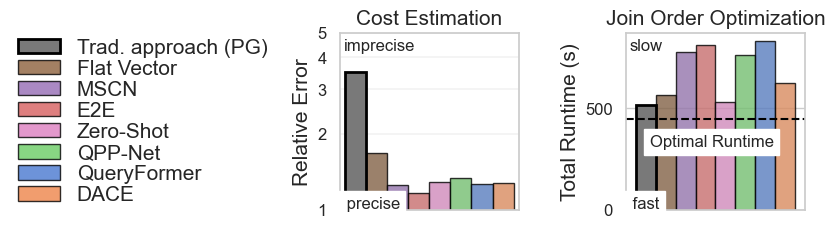

In [15]:
path = LocalPaths().data / "plots" / "motivating_plot.pdf"

fontsize = 15
fig, (q50, runtimes) = plt.subplots(1, 2, figsize=(6, 2.3))

# Filter only for database IMDB
training_results = training_results[training_results.database == "imdb"]
# ---------------------------- Plot Q50 ---------------------------- #
q50 = sns.barplot(x="database",
                  y="val_median_q_error_50",
                  hue="display_name",
                  data=training_results,
                  capsize=.0,
                  ax=q50,
                  width=1.0,
                  palette=ColorManager.COLOR_PALETTE,
                  errorbar=None,
                  edgecolor='black')

q50.set_ylim(1, 5)
q50.set_xlim(-0.53, 0.53)
q50.set_yscale("log")
q50.set_ylabel("Relative Error", fontsize=fontsize)
q50.set_xlabel("", fontsize=fontsize)

q50.set_yticks([1, 2, 3, 4, 5], labels=[1, 2, 3, 4, 5], minor=False, fontsize=fontsize * 0.8)
q50.set_xticklabels([])
q50.grid(False, axis='x', which='both')
q50.grid(True, axis='y', which='both', linewidth=0.3)
q50.set_title("Cost Estimation", fontsize=fontsize)

#for container in q50.containers:
#    q50.bar_label(container=container,
#                  rotation=0,
#                  fontsize=0.8 * fontsize,
#                  fmt="%2.2f",
#                  padding=1)

q50.get_legend().remove()

q50.annotate("imprecise",
              xy=(0.02, 0.90),
              xytext=(0.02, 0.90),
              fontsize=0.8 * fontsize,
              xycoords='axes fraction')

q50.annotate(" precise",
              xy=(0.01, 0.01),
              xytext=(0.01, 0.01),
              fontsize=0.8 * fontsize,
              xycoords='axes fraction',
              backgroundcolor='white')


sns.barplot(data=runtime_df.sum(axis=1).reset_index(), 
            x='index', 
            palette=ColorManager.COLOR_PALETTE,
            hue='index',
            y=0, 
            ax=runtimes,
            width=1,
            edgecolor='black')
runtimes.set_xlabel('')
runtimes.set_title('Join Order Optimization', fontsize=fontsize)
runtimes.set_xticklabels([])
runtimes.set_ylabel("Total Runtime (s)", fontsize=fontsize)
runtimes.set_yticklabels(runtimes.get_yticklabels(), fontsize=fontsize * 0.8)

runtimes.axhline(y=sum(minimal_runtimes), color='black', linestyle='--')
runtimes.annotate("Optimal Runtime",
                  #f"Optimal Runtime: {sum(minimal_runtimes):.0f}s", 
                  xy=(0.2, sum(minimal_runtimes)),
                  xytext=(0.2, sum(minimal_runtimes)*0.7), 
                  fontsize=0.8 * fontsize, 
                  backgroundcolor='white')
runtimes.annotate("slow",
                  xy=(0.02, 0.90),
                  xytext=(0.02, 0.90),
                  fontsize=0.8 * fontsize,
                  xycoords='axes fraction')

runtimes.annotate(" fast",
                  xy=(0.01, 0.01),
                  xytext=(0.01, 0.01),
                  fontsize=0.8 * fontsize,
                  xycoords='axes fraction',
                  backgroundcolor='white')

runtimes.set_xlim(-1, 8)

for ax in [q50, runtimes]:
    # Highlighting options
    bar_rects = ax.patches  # Get all the bar rectangles created by seaborn
    #bar_rects[0].set_width(1)  # Increase width of highlighted bar
    bar_rects[0].set_edgecolor('black')
    bar_rects[0].set_linewidth(2)
    bar_rects[0].set_zorder(2)
    for rect in bar_rects:
        rect.set_alpha(0.8)
    bar_rects[0].set_alpha(1.0)

legend_patches = [mpatches.Patch(color=color, label=model_name) for model_name, color in ColorManager.COLOR_PALETTE.items()][0:8]
legend_patches[0] = mpatches.Patch(label="Trad. approach (PG)", color=ColorManager.COLOR_PALETTE[ModelName.POSTGRES.DISPLAY_NAME])
for p in legend_patches[1:]:
    p.set_edgecolor('black')
    p.set_alpha(0.8)
legend_patches[0].set_edgecolor('black')
legend_patches[0].set_linewidth(2)
    
runtimes.legend(handles=legend_patches, 
                loc='center right', 
                bbox_to_anchor=(-1.9, 0.5), 
                edgecolor='white',  
                labelspacing=0.1,
                fontsize=fontsize)

#for i in runtimes.containers:
#    runtimes.bar_label(i,fmt='%.0f', label_type='edge', fontsize=fontsize*0.8)

plt.subplots_adjust(wspace=0.6)
fig.align_labels()
plt.savefig(path, bbox_inches='tight')
